In [ ]:
#Same import and cleaning procedure as in previous labs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


#Read in raw data
schoolData = pd.read_csv('C:/Users/jkras/Desktop/All_Data_By_School_Final.csv',low_memory=False)
testScores = pd.read_csv('C:/Users/jkras/Desktop/1516testresults_masking_removed.csv', low_memory=False)
raceData = pd.read_csv('C:/Users/jkras/Desktop/Ec_Pupils_Expanded (2017 Race Compositions by School).csv',low_memory=False)

In [2]:
#gotta merge 'em all!
piv_test = pd.pivot_table(testScores, values='Percent GLP',index=['School Code'],columns='Subject')

piv_test.index.name = 'unit_code'

piv_test.columns = [str(col) + '_GLP' for col in piv_test.columns]

piv_alltest = piv_test.reset_index()

schoolData_alltest = schoolData.merge(piv_alltest,how='left',on='unit_code')



racecols = ['Indian Male', 'Indian Female', 'Asian Male',
       'Asian Female', 'Hispanic Male', 'Hispanic Female', 'Black Male',
       'Black Female', 'White Male', 'White Female', 'Pacific Island Male',
       'Pacific Island Female', 'Two or  More Male', 'Two or  More Female',
       'Total', 'White', 'Black', 'Hispanic', 'Indian', 'Asian',
       'Pacific Island', 'Two or More', 'White_Pct', 'Majority_Minority']

racecols_renamed = [str(col) + '_RACE' for col in racecols]

racecol_rename_dict = {i:j for i,j in zip(racecols,racecols_renamed)}

raceData.rename(index=str, columns=racecol_rename_dict,inplace=True)

raceData['unit_code'] = raceData['unit_code'].apply(str)

for i,j in raceData.iterrows():
    
    if len(raceData['unit_code'][i]) == 5:
        raceData.loc[i, 'unit_code'] = '0' + raceData['unit_code'][i]
        

schoolData_testRace = schoolData_alltest.merge(raceData,how='left',on='unit_code')




region_df = testScores[['School Code','SBE District']]

region_df.rename(index=str, columns={'School Code':'unit_code'},inplace=True)

region_df_unique = region_df.drop_duplicates()

schoolData_testRaceRegion = schoolData_testRace.merge(region_df_unique,how='left',on='unit_code')

schoolData_testRaceRegion.shape

C:\Users\jkras\Anaconda3\lib\site-packages\pandas\core\frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


(2579, 352)

In [3]:
#expenditures variable list
exp_list = ['lea_total_expense_num','lea_salary_expense_pct','lea_benefits_expense_pct','lea_services_expense_pct',
'lea_supplies_expense_pct','lea_instruct_equip_exp_pct']

#teacher qualifications variable list
teach_list = ['flicensed_teach_pct', 'tchyrs_0thru3_pct', 'tchyrs_4thru10_pct', 'tchyrs_11plus_pct', 'class_teach_num', 'nbpts_num', 'advance_dgr_pct',
'_1yr_tchr_trnovr_pct', 'emer_prov_teach_pct', 'lateral_teach_pct', 'highqual_class_pct', 'lea_flicensed_teach_pct',
'lea_tchyrs_0thru3_pct', 'lea_tchyrs_4thru10_pct', 'lea_tchyrs_11plus_pct', 'lea_class_teach_num', 'lea_nbpts_num', 'lea_advance_dgr_pct',
'lea_1yr_tchr_trnovr_pct', 'lea_emer_prov_teach_pct', 'lea_lateral_teach_pct', 'lea_highqual_class_pct', 'lea_highqual_class_hp_pct',
'lea_highqual_class_lp_pct', 'lea_highqual_class_all_pct', 'lea_not_highqual_class_hp_pct', 'lea_not_highqual_class_lp_pct',
'lea_not_highqual_class_all_pct']

#performance scores list
grade_list = ['SPG Score', 'Reading  SPG Score', 'Math SPG Score', 'EVAAS Growth Score', 'Overall Achievement Score', 'Read Score', 'Math Score',
'Science Score', 'Math I Score', 'English II Score', 'Biology Score', 'The ACT Score', 'ACT WorkKeys Score', 'Math Course Rigor Score',
'Cohort Graduation Rate Standard Score']

In [4]:
#alias full data set, merged from 3 CSV files
all_df = schoolData_testRaceRegion

#cast SBE district to categorical to generate dummy indicators, dropping reference level, and concatenating to full data set (original SBE District feature will be dropped below)
all_df['SBE District'] = all_df['SBE District'].astype('category')
Coded_District = pd.get_dummies(all_df['SBE District'],drop_first=True)
all_df = pd.concat([all_df,Coded_District],axis=1)


#scale the SPG Score feature
all_df['SPG Score Scaled'] = all_df['SPG Score']*(.01)
pd.Series.to_frame(all_df['SPG Score Scaled']).shape

(2579, 1)

In [5]:
#mean impute missing scaled SPG Score on region-wise basis; where no regional data, mean impute across all regions
mean_filled = all_df.groupby('SBE District')['SPG Score Scaled'].transform('mean')
all_df['SPG Score Scaled'] = all_df['SPG Score Scaled'].fillna(mean_filled)

all_df['SPG Score Scaled'] = pd.Series.to_frame(all_df['SPG Score Scaled']).fillna(pd.Series.to_frame(all_df['SPG Score Scaled']).mean())

all_df.shape

(2579, 360)

In [6]:
#column names from Race data, used for subsetting below
racecols = ['Indian Male', 'Indian Female', 'Asian Male',
       'Asian Female', 'Hispanic Male', 'Hispanic Female', 'Black Male',
       'Black Female', 'White Male', 'White Female', 'Pacific Island Male',
       'Pacific Island Female', 'Two or  More Male', 'Two or  More Female',
       'Total', 'White', 'Black', 'Hispanic', 'Indian', 'Asian',
       'Pacific Island', 'Two or More', 'White_Pct', 'Majority_Minority']

#suffixing Race columns for clarity
racecols_renamed = [str(col) + '_RACE' for col in racecols]


#creating full list of column names for subsetting below
logsvm_list_excludeDistrict = teach_list + exp_list + ['SPG Score Scaled'] + ['Northeast Region', 'Northwest Region', 'Piedmont Triad Region', 'SandHills Region', 'Southeast Region', 'Southwest Region', 'Western Region']


#NA values for the features below are arguably too numerous to mean impute
logsvm_list_excludeDistrict.remove('emer_prov_teach_pct')

logsvm_list_excludeDistrict.remove('lateral_teach_pct')

logsvm_list_excludeDistrict.remove('lea_emer_prov_teach_pct')

#for filtering the features of the all_df data frame below
logsvm_list_noDistrict_race = logsvm_list_excludeDistrict + racecols_renamed




#subset features of interest for mean imputation for-block below
all_df_nocharter = all_df[all_df['type_cd_txt'] != 'Charter']
logsvm_df = all_df_nocharter[logsvm_list_noDistrict_race]
logsvm_df.shape


(2419, 63)

In [7]:
#mean impute missing values on region-wise basis for all features of interest; where no regional data, mean impute across all regions
for col,name in zip(logsvm_df.T.values,logsvm_df.columns):
    if pd.isnull(col).any():
        mean_fill_col = all_df.groupby('SBE District')[name].transform('mean')
        all_df[name] = all_df[name].fillna(mean_fill_col)
        
        all_df[name] = pd.Series.to_frame(all_df[name]).fillna(pd.Series.to_frame(all_df[name]).mean())


#re-subset features of interest after mean imputation above

all_df_nocharter = all_df[all_df['type_cd_txt'] != 'Charter']
all_df_nocharter.shape
logsvm_df = all_df_nocharter[logsvm_list_noDistrict_race]
logsvm_df.shape

(2419, 63)

In [8]:
#remove 15 records without Race data
logsvm_df = logsvm_df[logsvm_df['Total_RACE'].notnull()]



#create percentages
logsvm_df['Indian_RACE_Pct'] = logsvm_df['Indian_RACE']/logsvm_df['Total_RACE']
logsvm_df['Asian_RACE_Pct'] = logsvm_df['Asian_RACE']/logsvm_df['Total_RACE']
logsvm_df['Hispanic_RACE_Pct'] = logsvm_df['Hispanic_RACE']/logsvm_df['Total_RACE']
logsvm_df['Black_RACE_Pct'] = logsvm_df['Black_RACE']/logsvm_df['Total_RACE']
logsvm_df['Pacific Island_RACE_Pct'] = logsvm_df['Pacific Island_RACE']/logsvm_df['Total_RACE']
logsvm_df['Two or More_RACE_Pct'] = logsvm_df['Two or More_RACE']/logsvm_df['Total_RACE']

#masking variables to avoid division-by-zero errors
mask_Indian = (logsvm_df['Indian Male_RACE'] == 0) & (logsvm_df['Indian_RACE'] == 0)
mask_Asian = (logsvm_df['Asian Male_RACE'] == 0) & (logsvm_df['Asian_RACE'] == 0)
mask_Hispanic = (logsvm_df['Hispanic Male_RACE'] == 0) & (logsvm_df['Hispanic_RACE'] == 0)
mask_Black = (logsvm_df['Black Male_RACE'] == 0) & (logsvm_df['Black_RACE'] == 0)
mask_White = (logsvm_df['White Male_RACE'] == 0) & (logsvm_df['White_RACE'] == 0)
mask_Pacific = (logsvm_df['Pacific Island Male_RACE'] == 0) & (logsvm_df['Pacific Island_RACE'] == 0)
mask_TwoRace = (logsvm_df['Two or  More Male_RACE'] == 0) & (logsvm_df['Two or More_RACE'] == 0)

#create gender percentages
logsvm_df['Indian_RACE_Male_Pct'] = logsvm_df['Indian Male_RACE'].div(logsvm_df['Indian_RACE']).where(~mask_Indian,0)
logsvm_df['Asian_RACE_Male_Pct'] = logsvm_df['Asian Male_RACE'].div(logsvm_df['Asian_RACE']).where(~mask_Asian,0)
logsvm_df['Hispanic_RACE_Male_Pct'] = logsvm_df['Hispanic Male_RACE'].div(logsvm_df['Hispanic_RACE']).where(~mask_Hispanic,0)
logsvm_df['Black_RACE_Male_Pct'] = logsvm_df['Black Male_RACE'].div(logsvm_df['Black_RACE']).where(~mask_Black,0)
logsvm_df['White_RACE_Male_Pct'] = logsvm_df['White Male_RACE'].div(logsvm_df['White_RACE']).where(~mask_White,0)
logsvm_df['Pacific_Island_RACE_Male_Pct'] = logsvm_df['Pacific Island Male_RACE'].div(logsvm_df['Pacific Island_RACE']).where(~mask_Pacific,0)
logsvm_df['Two_or_More_RACE_Male_Pct'] = logsvm_df['Two or  More Male_RACE'].div(logsvm_df['Two or More_RACE']).where(~mask_TwoRace,0)


#drop multicolinear features
logsvm_df.drop(['Indian_RACE','Asian_RACE','Hispanic_RACE','Black_RACE','White_RACE','Pacific Island_RACE','Two or More_RACE',
                       'Indian Male_RACE','Asian Male_RACE','Hispanic Male_RACE','Black Male_RACE','White Male_RACE','Pacific Island Male_RACE','Two or  More Male_RACE',
                       'Indian Female_RACE','Asian Female_RACE','Hispanic Female_RACE','Black Female_RACE','White Female_RACE','Pacific Island Female_RACE','Two or  More Female_RACE','Total_RACE'],
              axis=1,inplace=True)

logsvm_df.drop(['lea_not_highqual_class_hp_pct', 'lea_not_highqual_class_lp_pct','lea_not_highqual_class_all_pct'],
              axis=1,inplace=True)

#check it out
len(logsvm_df.columns)

51

In [9]:
#check null value percentages
NA_report = logsvm_df.apply(lambda x: (sum(x.isnull().values)/len(x))*100, axis = 0)
with pd.option_context('display.max_rows', None):
    print("\n ****** Percentage of missing values in each attributes ********\n\n",NA_report)


 ****** Percentage of missing values in each attributes ********

 flicensed_teach_pct             0.0
tchyrs_0thru3_pct               0.0
tchyrs_4thru10_pct              0.0
tchyrs_11plus_pct               0.0
class_teach_num                 0.0
nbpts_num                       0.0
advance_dgr_pct                 0.0
_1yr_tchr_trnovr_pct            0.0
highqual_class_pct              0.0
lea_flicensed_teach_pct         0.0
lea_tchyrs_0thru3_pct           0.0
lea_tchyrs_4thru10_pct          0.0
lea_tchyrs_11plus_pct           0.0
lea_class_teach_num             0.0
lea_nbpts_num                   0.0
lea_advance_dgr_pct             0.0
lea_1yr_tchr_trnovr_pct         0.0
lea_lateral_teach_pct           0.0
lea_highqual_class_pct          0.0
lea_highqual_class_hp_pct       0.0
lea_highqual_class_lp_pct       0.0
lea_highqual_class_all_pct      0.0
lea_total_expense_num           0.0
lea_salary_expense_pct          0.0
lea_benefits_expense_pct        0.0
lea_services_expense_pct        

In [10]:
#preparing dataframes for train-test-split to build models
#separate target variable and predictors
X = logsvm_df.astype(np.float32)
X = X.drop('SPG Score Scaled',axis=1)
y = logsvm_df['SPG Score Scaled']

In [11]:
#scale training predictors
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [12]:
#train-test-split, 80% training data
from sklearn.model_selection import train_test_split
indices = range(2419)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y,indices,test_size=0.2, random_state=23233)

In [14]:
#grid search it, bro
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

#gimme those params
n_est = [300,400,500,600]
max_dep = [3,4,5]
min_split = [2,3]
lrn_rate = [0.01,0.05,0.1]
losses = ['ls','lad']

#plug 'em in
parameters = {'n_estimators': n_est, 'max_depth': max_dep, 'min_samples_split': min_split,
          'learning_rate': lrn_rate, 'loss': losses}

In [16]:
#build the classifier, stick in grid search
gbr = ensemble.GradientBoostingRegressor()
clf = GridSearchCV(gbr,parameters,cv=5)
#print(y_train.shape)
#print(X_train.shape)
print(clf)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [300, 400, 500, 600], 'max_depth': [3, 4, 5], 'min_samples_split': [2, 3], 'learning_rate': [0.01, 0.05, 0.1], 'loss': ['ls', 'lad']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)


In [17]:
#fit the model
clf.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [300, 400, 500, 600], 'max_depth': [3, 4, 5], 'min_samples_split': [2, 3], 'learning_rate': [0.01, 0.05, 0.1], 'loss': ['ls', 'lad']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [18]:
#one estimator to rule them all
clf.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=3, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [19]:
#generate predictions
predictions = clf.predict(X_test)

In [20]:
#let's see how we did
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

MSE: 0.0060


In [21]:
#best parameters
clf.best_params_

{'learning_rate': 0.05,
 'loss': 'ls',
 'max_depth': 3,
 'min_samples_split': 3,
 'n_estimators': 500}

In [22]:
#player 1 hi-score
clf.best_score_

0.60956634137481425

In [24]:
#how about all the other scores
clf.grid_scores_

C:\Users\jkras\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.53699, std: 0.02072, params: {'learning_rate': 0.01, 'loss': 'ls', 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 300},
 mean: 0.55936, std: 0.01939, params: {'learning_rate': 0.01, 'loss': 'ls', 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 400},
 mean: 0.57232, std: 0.02021, params: {'learning_rate': 0.01, 'loss': 'ls', 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 500},
 mean: 0.58146, std: 0.02126, params: {'learning_rate': 0.01, 'loss': 'ls', 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 600},
 mean: 0.53687, std: 0.02070, params: {'learning_rate': 0.01, 'loss': 'ls', 'max_depth': 3, 'min_samples_split': 3, 'n_estimators': 300},
 mean: 0.55947, std: 0.01944, params: {'learning_rate': 0.01, 'loss': 'ls', 'max_depth': 3, 'min_samples_split': 3, 'n_estimators': 400},
 mean: 0.57260, std: 0.02006, params: {'learning_rate': 0.01, 'loss': 'ls', 'max_depth': 3, 'min_samples_split': 3, 'n_estimators': 500},
 mean: 0.58139, std: 0.02163, para

In [62]:
#let's reign in those parameters a bit; probably didn't need all that firepower
params = {'n_estimators': 100, 'max_depth': 4, 'min_samples_split':2,
          'learning_rate': 0.05, 'loss': 'ls'}

#create classifier instance with specified parameters
clf_2 = ensemble.GradientBoostingRegressor(**params)

#create indices, in case we need 'em
indices = range(2419)

#train_test lickity-split
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.2, random_state=111)

#and fit
clf_2.fit(X_train, y_train)

#how'd we do?
mse = mean_squared_error(y_test, clf_2.predict(X_test))
print("MSE: %.4f" % mse)

MSE: 0.0058


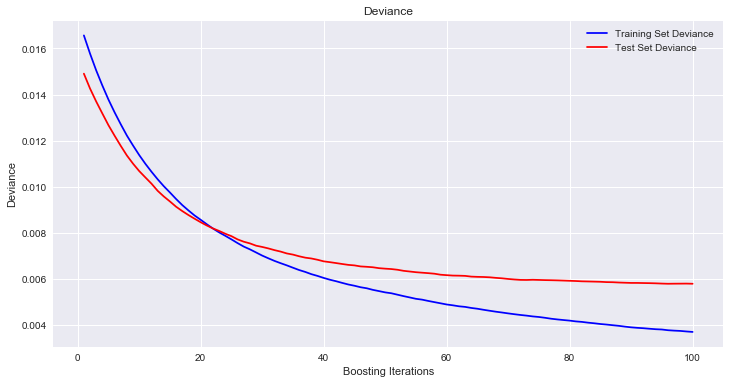

In [75]:
# Plot training/testing deviance

#array of zeros in which to put test scores
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

#fill in those test scores at every boosting iteration
for i, y_pred in enumerate(clf_2.staged_predict(X_test)):
    test_score[i] = clf_2.loss_(y_test, y_pred)

#plot it out, with the number of estimators used
plt.figure(figsize=(12, 6))
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf_2.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

In [80]:
#how important were the features? Note: non-parametric regressor means no positive/negative coefficients!
clf_2.feature_importances_

array([ 0.00957129,  0.03583796,  0.00512699,  0.0045813 ,  0.0517185 ,
        0.02825033,  0.01605835,  0.02256224,  0.01843135,  0.01870447,
        0.01349302,  0.00752772,  0.01874239,  0.05446586,  0.02401003,
        0.01263269,  0.02000506,  0.00837534,  0.01502949,  0.01476165,
        0.01853339,  0.02088   ,  0.02732348,  0.01965504,  0.00640381,
        0.00101919,  0.00929086,  0.01739444,  0.00154485,  0.007058  ,
        0.00281645,  0.00407876,  0.00151392,  0.00335048,  0.001283  ,
        0.14351774,  0.        ,  0.01265814,  0.07954778,  0.05174929,
        0.04830863,  0.00270841,  0.01494642,  0.00157944,  0.00335395,
        0.01006613,  0.05254498,  0.0238654 ,  0.00095741,  0.01216456])

In [86]:
#storing the importances
feature_importance = clf_2.feature_importances_

#scaling importances by their maximum value
feature_importance = 100.0 * (feature_importance / feature_importance.max())

#sorting 'em for neat plotting
sorted_idx = np.argsort(feature_importance)

#gimme a little bit of extra space on the y-axis of that plot
pos = np.arange(sorted_idx.shape[0]) + .5

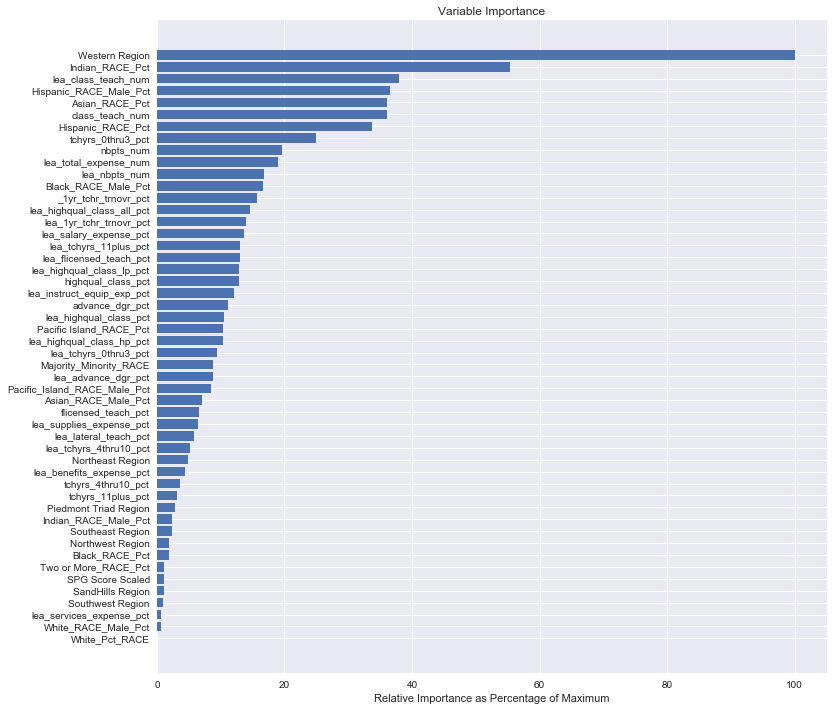

In [87]:
plt.figure(figsize=(12, 12))

#turn it sideways
plt.barh(pos, feature_importance[sorted_idx], align='center')

#note: gotta make the features an array before we sort 'em
plt.yticks(pos, np.asarray(list(logsvm_df.columns))[sorted_idx])
plt.xlabel('Relative Importance as Percentage of Maximum')
plt.title('Variable Importance')
plt.show()

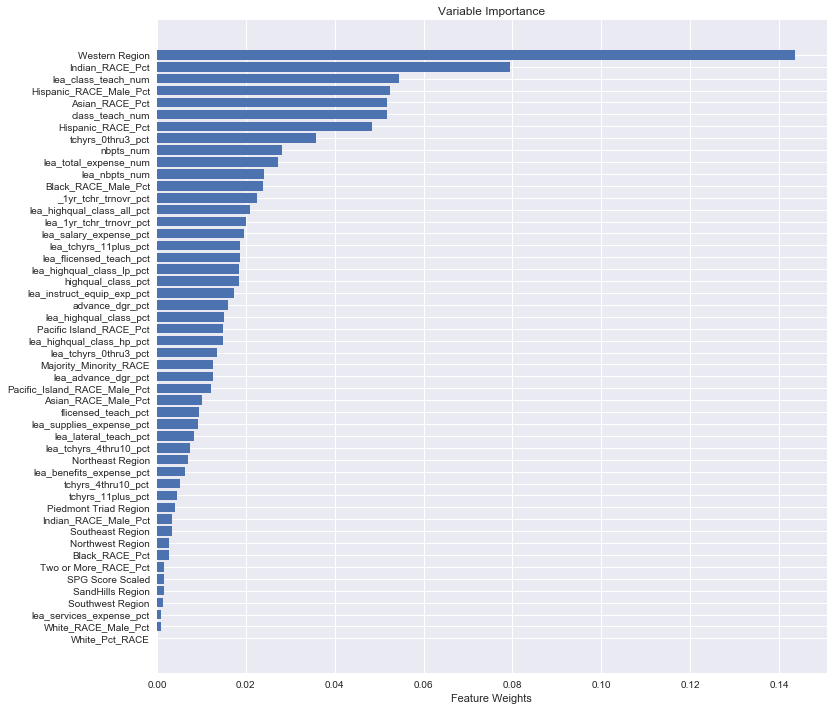

In [88]:
#let's see that again! -- this time, with raw feature importance values
feature_importance = clf_2.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12, 12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.asarray(list(logsvm_df.columns))[sorted_idx])
plt.xlabel('Feature Weights')
plt.title('Variable Importance')
plt.show()

In [133]:
#RECURSIVE FEATURE ELIMINATION & REMODELING w/ MOST IMPORTANT FEATURES

In [134]:
#NOTE: GRADIENT BOOSTING REGRESSION IS NON-PARAMETRIC -- NO FEATURE COEFFICIENTS CAN BE RETRIEVED, ONLY FEATURE IMPORTANCES!

In [135]:
#CF: https://stackoverflow.com/questions/47106385/determine-why-features-are-important-in-decision-tree-models

In [136]:
#NOTE ALSO: FURTHER EXPLORATION OF POSITIVE/NEGATIVE FEATURE INFLUENCE ON THE TARGET VARIABLE 
#                  CAN BE CONDUCTED THROUGH PARTIAL DEPEDENCE PLOTS

In [137]:
#CF: http://rstudio-pubs-static.s3.amazonaws.com/283647_c3ab1ccee95a403ebe3d276599a85ab8.html

In [138]:
#(WE WOULD HAVE TO SEE HOW THIS IS DONE IN PYTHON, FOR PURPOSES OF INTERPRETATION)

In [94]:
#let's see if we can pare those features down

#indices and train-test-lickity-split-and-quit
indices = range(2419)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.2, random_state=1111)

In [106]:
#scikit learn is our friend
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

#same parameters as above
params = {'n_estimators': 100, 'max_depth': 4, 'min_samples_split':2,
          'learning_rate': 0.05, 'loss': 'ls'}

#build classifier instance w/ specified parameters
clf_3 = ensemble.GradientBoostingRegressor(**params)

#plug it into recursive feature elimination with 10-fold cross-validation and MSE scoring metric
rfecv = RFECV(estimator=clf_3, step=1, cv=KFold(10), scoring='neg_mean_squared_error')

#pipeline is gonna help us retrieve the feature names
#name your classifier and estimator whatever you want, and stick em in tuples
pipeline = Pipeline([
    ('rfe_cv',rfecv),
    ('clf',clf_3)
])

#fit that pipe, bro
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('rfe_cv', RFECV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
   estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=...s=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False))])

In [121]:
#how'd we do on the test set?
mse = mean_squared_error(y_test, rfecv.predict(X_test))
print("MSE: %.4f" % mse)

MSE: 0.0078


In [118]:
#how many features did we really need?
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 19


In [113]:
#the .named_steps attribute from the pipeline can be indexed with whatever you named your RFECV estimator
#from there you use the .support_ attribute to help you get the feature names
#note: support_feat is just a boolean mask you can apply to the full array of features to get just the ones used by the model
support_feat = pipeline.named_steps['rfe_cv'].support_

In [116]:
#aliasing that full array of features
feat_names = np.array(list(logsvm_df.drop('SPG Score Scaled',axis=1).columns))

In [117]:
#and pulling out the feature names with boolean masking
feat_names[support_feat]

array(['tchyrs_0thru3_pct', 'class_teach_num', 'nbpts_num',
       '_1yr_tchr_trnovr_pct', 'highqual_class_pct',
       'lea_tchyrs_11plus_pct', 'lea_class_teach_num',
       'lea_1yr_tchr_trnovr_pct', 'lea_highqual_class_pct',
       'lea_highqual_class_lp_pct', 'lea_highqual_class_all_pct',
       'lea_supplies_expense_pct', 'lea_instruct_equip_exp_pct',
       'White_Pct_RACE', 'Asian_RACE_Pct', 'Hispanic_RACE_Pct',
       'Black_RACE_Pct', 'Black_RACE_Male_Pct', 'White_RACE_Male_Pct'], 
      dtype='<U28')

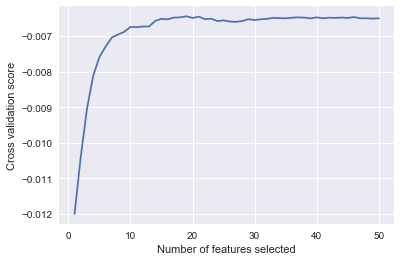

In [119]:
#checking out the curve of those cross-validation scores-- not getting out any extra juice after around 19 features
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [139]:
#NOW-- let's do it one more time, using just the most important features

In [140]:
#NOTE: (if we were really being statistically vigilant and had tons of data, we'd do this on a hold-out validation set)

In [125]:
#preparing dataframes for train-test-split
#separate target variable and predictors
X = logsvm_df[['tchyrs_0thru3_pct', 'class_teach_num', 'nbpts_num',
       '_1yr_tchr_trnovr_pct', 'highqual_class_pct',
       'lea_tchyrs_11plus_pct', 'lea_class_teach_num',
       'lea_1yr_tchr_trnovr_pct', 'lea_highqual_class_pct',
       'lea_highqual_class_lp_pct', 'lea_highqual_class_all_pct',
       'lea_supplies_expense_pct', 'lea_instruct_equip_exp_pct',
       'White_Pct_RACE', 'Asian_RACE_Pct', 'Hispanic_RACE_Pct',
       'Black_RACE_Pct', 'Black_RACE_Male_Pct', 'White_RACE_Male_Pct']].astype(np.float32)
y = logsvm_df['SPG Score Scaled']

In [126]:
#scale training predictors
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [127]:
#same hyperparameters
params = {'n_estimators': 100, 'max_depth': 4, 'min_samples_split':2,
          'learning_rate': 0.05, 'loss': 'ls'}

#building that classifier
clf_4 = ensemble.GradientBoostingRegressor(**params)

#same old drill
indices = range(2419)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.2, random_state=333)

#fit, hit, and quit
clf_4.fit(X_train, y_train)

#score it
mse = mean_squared_error(y_test, clf_4.predict(X_test))
print("MSE: %.4f" % mse)

MSE: 0.0074


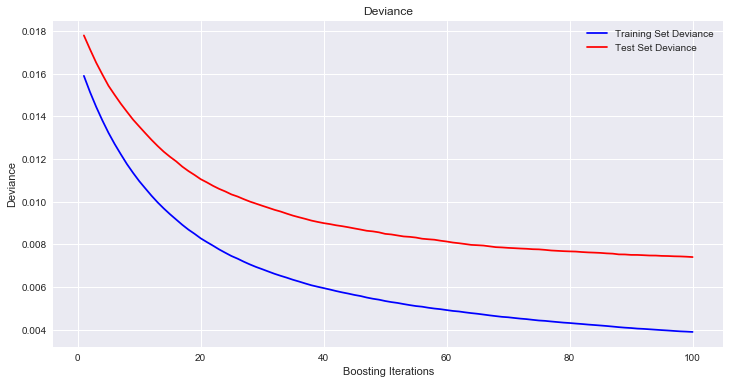

In [128]:
#plot training/testing deviance

#same deal as before
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf_4.staged_predict(X_test)):
    test_score[i] = clf_4.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf_4.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

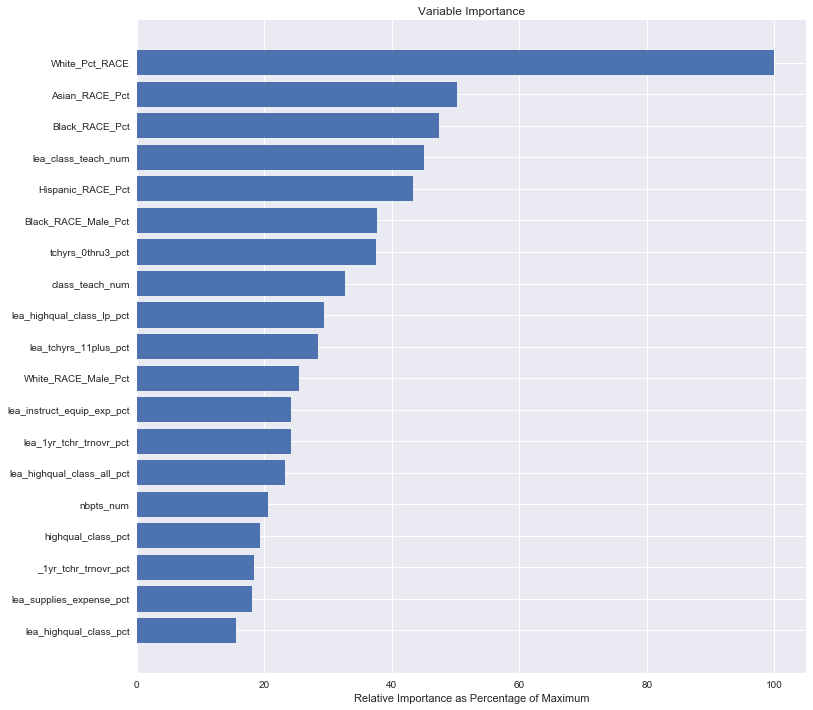

In [130]:
#plot feature importances scaled to their max value
feature_importance = clf_4.feature_importances_

feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12, 12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feat_names[support_feat][sorted_idx])
plt.xlabel('Relative Importance as Percentage of Maximum')
plt.title('Variable Importance')
plt.show()

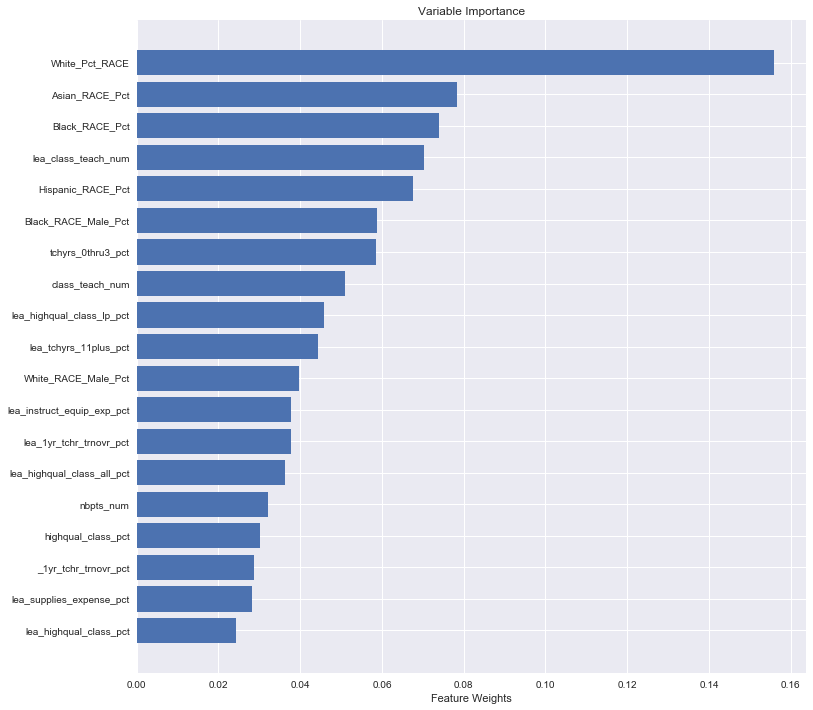

In [131]:
#plot raw feature importances
feature_importance = clf_4.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12, 12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feat_names[support_feat][sorted_idx])
plt.xlabel('Feature Weights')
plt.title('Variable Importance')
plt.show()

In [141]:
#This is definitely more interpretable-- but for keener inference, we should still check out partial dependency plots!

In [190]:
#Dense Neural Network Classification of A-Grade vs. F-Grade Performing Schools 

In [191]:
#create categorization bins and names for scaled SPG Score
bins = [0.0,0.4,0.55,0.7,0.85,1.0]
group_names = ['F','D','C','B','A']

#create SPG Score Grade feature, based on binned SPG Score
logsvm_df['SPG Score_GRADE'] = pd.cut(logsvm_df['SPG Score Scaled'],bins,labels=group_names,include_lowest=True,right=False,precision=6)
#logsvm_df['SPG Score_GRADE'].tail(20)

#generate categorical codes: 0 = F, 1 = D, 2 = C, 3 = B, 4 = A
logsvm_df['SPG Score_GRADE'] = logsvm_df['SPG Score_GRADE'].cat.codes
#logsvm_df['SPG Score_GRADE'].tail(20)


#preparing dataframes for train-test-split to build models; SPG Score_GRADE used as classification target
#separate target variable and predictors, only selecting records with Grades A = 4 and F = 0
X = logsvm_df[(logsvm_df['SPG Score_GRADE'] == 0) | (logsvm_df['SPG Score_GRADE'] == 4)]
X = X.drop(['SPG Score_GRADE','SPG Score Scaled'],axis=1)
y = logsvm_df['SPG Score_GRADE'][(logsvm_df['SPG Score_GRADE'] == 0) | (logsvm_df['SPG Score_GRADE'] == 4)]

In [192]:
#verifying correct shape
print(X.shape)
print(y.shape)

(255, 50)
(255,)


In [193]:
#checking frequency counts of A-Grade and F-Grade classes
y.value_counts()

4    136
0    119
Name: SPG Score_GRADE, dtype: int64

In [194]:
#viewing target variable as a dataframe
pd.DataFrame(y).head(10)

,SPG Score_GRADE
116,4
139,4
175,4
183,4
186,4
218,0
220,4
246,4
261,4
294,4


In [195]:
#replacing A-Grade value (4) with 1 to facilitate binary classification below
pd.DataFrame(y.replace(to_replace=4, value=1)).head(10)

,SPG Score_GRADE
116,1
139,1
175,1
183,1
186,1
218,0
220,1
246,1
261,1
294,1


In [196]:
#performing the above replacement mapping 'in place' to make it permanent
pd.DataFrame(y.replace(to_replace=4, value=1, inplace=True))

""


In [197]:
#verifying replacement mapping
y[:10]

116    1
139    1
175    1
183    1
186    1
218    0
220    1
246    1
261    1
294    1
Name: SPG Score_GRADE, dtype: int8

In [205]:
#too legit 2 (not) train-test-split and quit
indices = range(255)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.2, random_state=555)

In [206]:
#needed imports for DNN classifier script below
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import os
import tensorflow as tf

In [207]:
#Dense Neural Net Binary Classifier (10 X 20 X 10 hidden layers) w/ rectified linear unit activation (500 training steps)

In [210]:
def main():
    
    # Specify that all features have real-value data
    feature_columns = [tf.feature_column.numeric_column("x", shape=[50])]

    # Build 3 layer DNN with 10, 20, 10 units respectively.
    classifier = tf.estimator.DNNClassifier(feature_columns=feature_columns,
                                          hidden_units=[10, 20, 10],
                                          n_classes=2,
                                          model_dir="/tmp/NN_model")

    # Define the training inputs
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"x": np.array(X_train)},
        y=np.array(y_train),
        num_epochs=None,
        shuffle=True)

    # Train model
    classifier.train(input_fn=train_input_fn, steps=500)

    # Define the test inputs
    test_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"x": np.array(X_test)},
        y=np.array(y_test),
        num_epochs=1,
        shuffle=False)

    # Evaluate accuracy
    accuracy_score = classifier.evaluate(input_fn=test_input_fn)["accuracy"]
    print("\nTest Accuracy: {0:f}\n".format(accuracy_score))
    
if __name__ == "__main__":
    main()

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/NN_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002AA75CD69B0>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/NN_model\model.ckpt-139000
INFO:tensorflow:Saving checkpoints for 139001 into /tmp/NN_model\model.ckpt.
INFO:tensorflow:loss = 6.92923, step = 139001
INFO:tensorflow:global_step/sec: 720.107
INFO:tensorflow:loss = 4.80946, step = 139101 (0.140 sec)
INFO:tensorflow:global_step/sec: 957.481
INFO:tensorflow:loss = 4.00356, step = 

In [214]:
#feature list from cleaning procedure above
len(logsvm_list_noDistrict_race)

63

In [229]:
#adding target variable to feature list
feature_mask = logsvm_list_noDistrict_race + ['Overall Achievement Score']
len(feature_mask)

64

In [230]:
#subsetting cleaned data with feature list masking
logsvm_df2 = all_df_nocharter[feature_mask]
logsvm_df2.shape

(2419, 64)

In [231]:
#check null value percentages
NA_report = logsvm_df2.apply(lambda x: (sum(x.isnull().values)/len(x))*100, axis = 0)
with pd.option_context('display.max_rows', None):
    print("\n ****** Percentage of missing values in each attributes ********\n\n",NA_report)


 ****** Percentage of missing values in each attributes ********

 flicensed_teach_pct               0.000000
tchyrs_0thru3_pct                 0.000000
tchyrs_4thru10_pct                0.000000
tchyrs_11plus_pct                 0.000000
class_teach_num                   0.000000
nbpts_num                         0.000000
advance_dgr_pct                   0.000000
_1yr_tchr_trnovr_pct              0.000000
highqual_class_pct                0.000000
lea_flicensed_teach_pct           0.000000
lea_tchyrs_0thru3_pct             0.000000
lea_tchyrs_4thru10_pct            0.000000
lea_tchyrs_11plus_pct             0.000000
lea_class_teach_num               0.000000
lea_nbpts_num                     0.000000
lea_advance_dgr_pct               0.000000
lea_1yr_tchr_trnovr_pct           0.000000
lea_lateral_teach_pct             0.000000
lea_highqual_class_pct            0.000000
lea_highqual_class_hp_pct         0.000000
lea_highqual_class_lp_pct         0.000000
lea_highqual_class_all_pct   

In [232]:
#drop rows with null values for target variable
knnR_df = logsvm_df2[logsvm_df2['Overall Achievement Score'].notnull()]

In [233]:
#check shape of final dataframe
knnR_df.shape

(2185, 64)

In [234]:
#scale the Overall Achievement Score feature
knnR_df['Overall Achievement Score Scaled'] = knnR_df['Overall Achievement Score']*(.01)
knnR_df.shape

C:\Users\jkras\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


(2185, 65)

In [240]:
#checking result of data type conversion below
type(knnR_df['Overall Achievement Score Scaled'].iloc[0].astype(np.float32))

numpy.float32

In [241]:
#training feature data type conversion; dropping targets from training dataframe; setting target variable
knnR_df2 = knnR_df.astype(np.float32)
X = knnR_df2.drop(['Overall Achievement Score','Overall Achievement Score Scaled'],axis=1)
y = knnR_df['Overall Achievement Score Scaled'].astype(np.float32)

In [244]:
#verify correct shape
print(X.shape)
print(y.shape)

(2185, 63)
(2185,)


In [245]:
#scale training predictors
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [246]:
#train-test-split, 80% training data
from sklearn.model_selection import train_test_split
indices = range(2185)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.2, random_state=2222)

In [247]:
#classifier, grid search, and metric imports
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [254]:
#gimme those params
n_neigh = [1,3,5]
weightz = ['uniform','distance']
algo = ['ball_tree','kd_tree']
leaf_sz = [20,30,50]
metrik = ['minkowski','euclidean']

#plug 'em in
parameters = {'n_neighbors': n_neigh, 'weights': weightz, 'algorithm': algo,
          'leaf_size': leaf_sz, 'metric': metrik}

In [255]:
#build the classifier, stick in grid search
knnR = KNeighborsRegressor()
clf = GridSearchCV(knnR,parameters,cv=5)
#print(y_train.shape)
#print(X_train.shape)
print(clf)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 3, 5], 'weights': ['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree'], 'leaf_size': [20, 30, 50], 'metric': ['minkowski', 'euclidean']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)


In [256]:
#fit the model
clf.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 3, 5], 'weights': ['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree'], 'leaf_size': [20, 30, 50], 'metric': ['minkowski', 'euclidean']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [257]:
#one estimator to rule them all
clf.best_estimator_

KNeighborsRegressor(algorithm='ball_tree', leaf_size=20, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='distance')

In [258]:
#generate predictions
predictions = clf.predict(X_test)

In [259]:
#let's see how we did
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

MSE: 0.0077


In [260]:
#best parameters
clf.best_params_

{'algorithm': 'ball_tree',
 'leaf_size': 20,
 'metric': 'minkowski',
 'n_neighbors': 5,
 'weights': 'distance'}

In [306]:
#refining the hyperparameters
params = {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'ball_tree',
          'leaf_size': 20, 'metric': 'minkowski'}

#create classifier instance with specified parameters
clf_3 = KNeighborsRegressor(**params)

#create indices, in case we need 'em
indices = range(2185)

#train_test lickity-split
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.2, random_state=333)

In [307]:
#and fit
clf_3.fit(X_train, y_train)

KNeighborsRegressor(algorithm='ball_tree', leaf_size=20, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=7, p=2,
          weights='distance')

In [308]:
#how'd we do?
mse = mean_squared_error(y_test, clf_3.predict(X_test))
print("MSE: %.4f" % mse)

MSE: 0.0079


In [315]:
#R-squared coefficient of determination
clf_3.score(X_test, y_test, sample_weight=None)

0.94201455151932389

In [323]:
#checking out the KNN graph
#np.set_printoptions(threshold=np.nan)

#KNN_graph = clf_3.kneighbors_graph(X_test)
#KNN_graph.toarray()

In [332]:
#drop rows with null values for target variable
gbr_df = logsvm_df2[logsvm_df2['Overall Achievement Score'].notnull()]

In [333]:
#check shape of final dataframe
gbr_df.shape

(2185, 64)

In [334]:
#scale the Overall Achievement Score feature
gbr_df['Overall Achievement Score Scaled'] = gbr_df['Overall Achievement Score']*(.01)
gbr_df.shape

C:\Users\jkras\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


(2185, 65)

In [335]:
#checking result of data type conversion below
type(gbr_df['Overall Achievement Score Scaled'].iloc[0].astype(np.float32))

numpy.float32

In [336]:
#training feature data type conversion; dropping targets from training dataframe; setting target variable
gbr_df2 = gbr_df.astype(np.float32)
X = gbr_df2.drop(['Overall Achievement Score','Overall Achievement Score Scaled'],axis=1)
y = gbr_df['Overall Achievement Score Scaled'].astype(np.float32)

In [337]:
#verify correct shape
print(X.shape)
print(y.shape)

(2185, 63)
(2185,)


In [338]:
#scale training predictors
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [339]:
#train-test-split, 80% training data
from sklearn.model_selection import train_test_split
indices = range(2185)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.2, random_state=1234)

In [340]:
#grid search it, bro
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [341]:
#gimme those params
n_est = [300,400,500,600]
max_dep = [3,4,5]
min_split = [2,3]
lrn_rate = [0.01,0.05,0.1]
losses = ['ls','lad']

In [342]:
#plug 'em in
parameters = {'n_estimators': n_est, 'max_depth': max_dep, 'min_samples_split': min_split,
          'learning_rate': lrn_rate, 'loss': losses}

In [343]:
#build the classifier, stick in grid search
gbr = ensemble.GradientBoostingRegressor()
clf_5 = GridSearchCV(gbr,parameters,cv=5)
#print(y_train.shape)
#print(X_train.shape)
print(clf_5)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [300, 400, 500, 600], 'max_depth': [3, 4, 5], 'min_samples_split': [2, 3], 'learning_rate': [0.01, 0.05, 0.1], 'loss': ['ls', 'lad']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)


In [344]:
#fit the model
clf_5.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [300, 400, 500, 600], 'max_depth': [3, 4, 5], 'min_samples_split': [2, 3], 'learning_rate': [0.01, 0.05, 0.1], 'loss': ['ls', 'lad']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [345]:
#one estimator to rule them all
clf_5.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [346]:
#generate predictions
predictions = clf_5.predict(X_test)

In [347]:
#let's see how we did
mse = mean_squared_error(y_test, clf_5.predict(X_test))
print("MSE: %.4f" % mse)

MSE: 0.0006


In [348]:
#best parameters
clf_5.best_params_

{'learning_rate': 0.05,
 'loss': 'ls',
 'max_depth': 3,
 'min_samples_split': 2,
 'n_estimators': 500}

In [349]:
#player 1 hi-score
clf_5.best_score_

0.97899595557971364

In [350]:
#refining hyperparameters
params = {'n_estimators': 500, 'max_depth': 3, 'min_samples_split':2,
          'learning_rate': 0.05, 'loss': 'ls'}

#create classifier instance with specified parameters
clf_6 = ensemble.GradientBoostingRegressor(**params)

#create indices, in case we need 'em
indices = range(2185)

#train_test lickity-split
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.2, random_state=4444)

In [351]:
#and fit
clf_6.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [352]:
#WARNING: We're doing suspiciously well...! (See below)

mse = mean_squared_error(y_test, clf_6.predict(X_test))
print("MSE: %.4f" % mse)

MSE: 0.0006


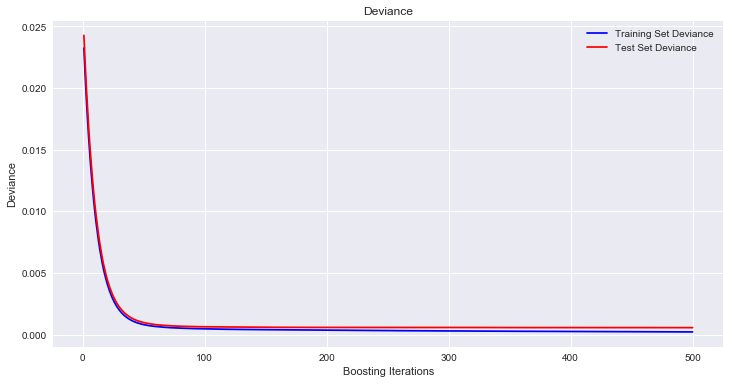

In [353]:
# Plot training/testing deviance

#array of zeros in which to put test scores
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

#fill in those test scores at every boosting iteration
for i, y_pred in enumerate(clf_6.staged_predict(X_test)):
    test_score[i] = clf_6.loss_(y_test, y_pred)

#plot it out, with the number of estimators used
plt.figure(figsize=(12, 6))
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf_6.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

In [354]:
#how important were the features? Note: non-parametric regressor means no positive/negative coefficients!
clf_6.feature_importances_

array([  1.68295097e-02,   1.90254677e-02,   3.02702720e-02,
         1.60914277e-02,   1.93670380e-02,   2.08959856e-02,
         2.49014538e-02,   2.25464367e-02,   1.09967382e-02,
         1.62206539e-02,   3.72260252e-02,   2.56483978e-02,
         9.76753124e-03,   1.58188143e-02,   1.22560344e-02,
         2.17632107e-02,   2.58102973e-02,   2.57557476e-02,
         1.30726186e-02,   6.31898376e-03,   2.53321786e-03,
         6.24453238e-03,   6.68139811e-03,   3.01474468e-03,
         2.12727480e-03,   1.25470662e-02,   1.15621031e-02,
         1.22057546e-02,   4.01494159e-03,   1.00168026e-02,
         7.52501260e-03,   1.67818149e-01,   9.29875748e-04,
         2.35790731e-06,   7.36941559e-04,   2.56633120e-04,
         0.00000000e+00,   7.17246502e-04,   2.01069328e-04,
         1.44733195e-02,   7.43352786e-03,   2.58845776e-02,
         8.93501802e-03,   2.85113911e-02,   3.00223871e-02,
         1.82808679e-02,   1.21427388e-02,   1.48930198e-02,
         1.33171368e-02,

In [355]:
#storing the importances
feature_importance = clf_6.feature_importances_

#scaling importances by their maximum value
feature_importance = 100.0 * (feature_importance / feature_importance.max())

#sorting 'em for neat plotting
sorted_idx = np.argsort(feature_importance)

#gimme a little bit of extra space on the y-axis of that plot
pos = np.arange(sorted_idx.shape[0]) + .5

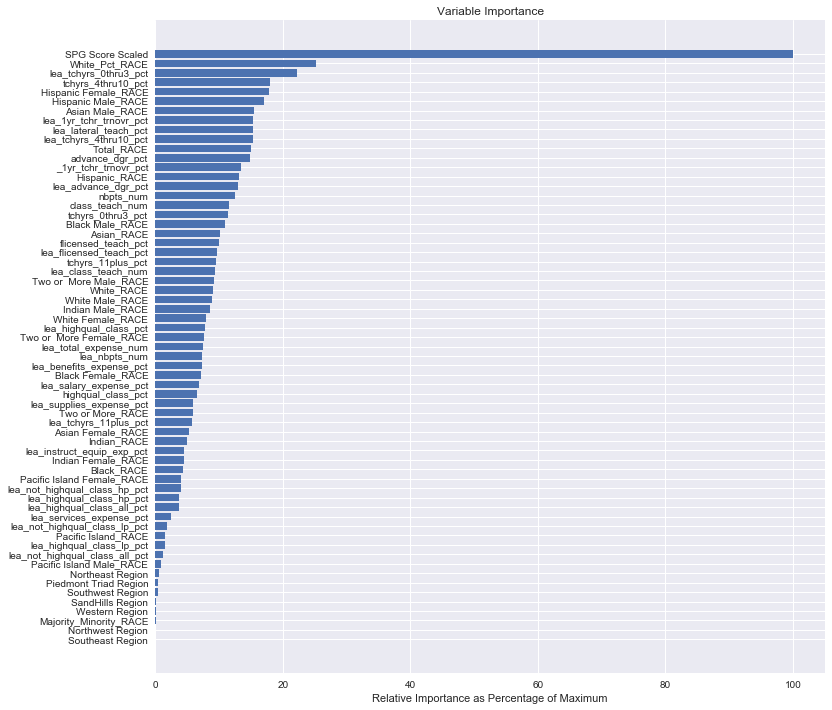

In [356]:
#NOTE: the SPG Score totally overpowers the regressor, and is not likely to be available as a feature in a real-life use-case

#Meaning, the SPG Score is a good proxy for the Overall Achievement Score

#However, if we had the one score, we probably wouldn't need to figure out the other to get a decent gauge on performance!

plt.figure(figsize=(12, 12))

#turn it sideways
plt.barh(pos, feature_importance[sorted_idx], align='center')

#note: gotta make the features an array before we sort 'em
plt.yticks(pos, np.asarray(list(gbr_df2.drop(['Overall Achievement Score','Overall Achievement Score Scaled'],axis=1).columns))[sorted_idx])
plt.xlabel('Relative Importance as Percentage of Maximum')
plt.title('Variable Importance')
plt.show()

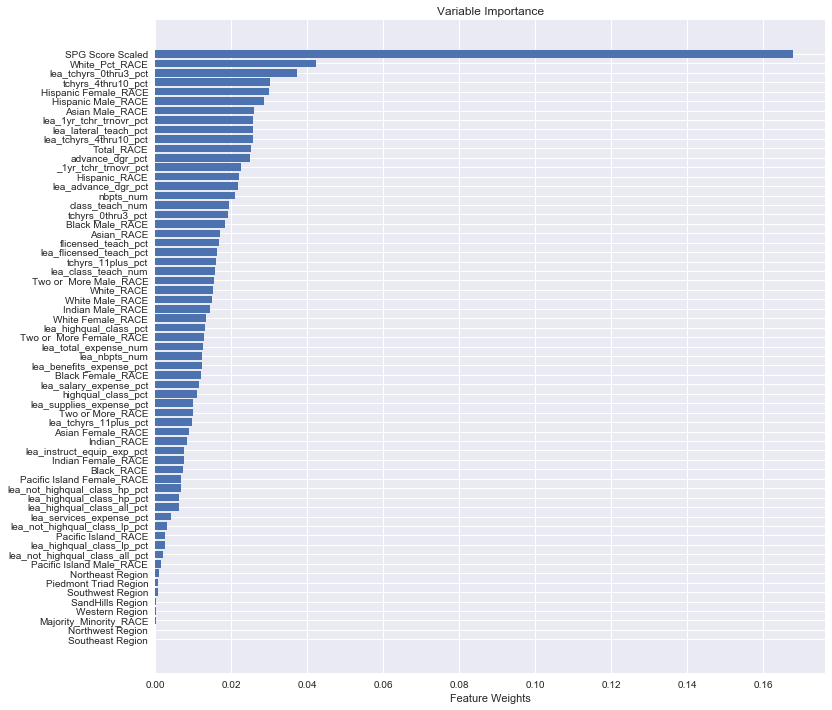

In [357]:
#let's see that again! -- this time, with raw feature importance values
feature_importance = clf_6.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12, 12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.asarray(list(gbr_df2.drop(['Overall Achievement Score','Overall Achievement Score Scaled'],axis=1).columns))[sorted_idx])
plt.xlabel('Feature Weights')
plt.title('Variable Importance')
plt.show()

In [358]:
#This time, let's get rid of the overpowering SPG Score and use recursive feature elimination

In [359]:
#training feature data type conversion; dropping targets from training dataframe; setting target variable
gbr_df2 = gbr_df.astype(np.float32)
X = gbr_df2.drop(['Overall Achievement Score','Overall Achievement Score Scaled','SPG Score Scaled'],axis=1)
y = gbr_df['Overall Achievement Score Scaled'].astype(np.float32)

#verify correct shape
print(X.shape)
print(y.shape)

(2185, 62)
(2185,)


In [360]:
#scale training predictors
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [361]:
#train-test-split, 80% training data
from sklearn.model_selection import train_test_split
indices = range(2185)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.2, random_state=2345)

In [362]:
#scikit learn is our friend
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

#same optimal hyperparameters identified by GridSearchCV
params = {'n_estimators': 500, 'max_depth': 3, 'min_samples_split':2,
          'learning_rate': 0.05, 'loss': 'ls'}

#create classifier instance with specified parameters
clf_7 = ensemble.GradientBoostingRegressor(**params)

#plug it into recursive feature elimination with 10-fold cross-validation and MSE scoring metric
rfecv = RFECV(estimator=clf_7, step=1, cv=KFold(10), scoring='neg_mean_squared_error')

#pipeline is gonna help us retrieve the feature names
#name your classifier and estimator whatever you want, and stick em in tuples
pipeline = Pipeline([
    ('rfe_cv',rfecv),
    ('clf',clf_7)
])

In [363]:
#fit that pipe, bro
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('rfe_cv', RFECV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
   estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=...s=500, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False))])

In [364]:
#how'd we do on the test set?
mse = mean_squared_error(y_test, rfecv.predict(X_test))
print("MSE: %.4f" % mse)

MSE: 0.0078


In [365]:
#how many features did we really need?
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 51


In [366]:
#the .named_steps attribute from the pipeline can be indexed with whatever you named your RFECV estimator
#from there you use the .support_ attribute to help you get the feature names
#note: support_feat is just a boolean mask you can apply to the full array of features to get just the ones used by the model
support_feat = pipeline.named_steps['rfe_cv'].support_

In [367]:
#aliasing that full array of features
feat_names = np.array(list(gbr_df2.drop(['Overall Achievement Score','Overall Achievement Score Scaled','SPG Score Scaled'],axis=1).columns))

In [368]:
#and pulling out the feature names with boolean masking
feat_names[support_feat]

array(['flicensed_teach_pct', 'tchyrs_0thru3_pct', 'tchyrs_4thru10_pct',
       'tchyrs_11plus_pct', 'class_teach_num', 'nbpts_num',
       'advance_dgr_pct', '_1yr_tchr_trnovr_pct', 'highqual_class_pct',
       'lea_flicensed_teach_pct', 'lea_tchyrs_0thru3_pct',
       'lea_tchyrs_4thru10_pct', 'lea_tchyrs_11plus_pct',
       'lea_class_teach_num', 'lea_nbpts_num', 'lea_advance_dgr_pct',
       'lea_1yr_tchr_trnovr_pct', 'lea_lateral_teach_pct',
       'lea_highqual_class_pct', 'lea_highqual_class_hp_pct',
       'lea_highqual_class_lp_pct', 'lea_highqual_class_all_pct',
       'lea_not_highqual_class_hp_pct', 'lea_not_highqual_class_all_pct',
       'lea_total_expense_num', 'lea_salary_expense_pct',
       'lea_benefits_expense_pct', 'lea_services_expense_pct',
       'lea_supplies_expense_pct', 'lea_instruct_equip_exp_pct',
       'SandHills Region', 'Indian Female_RACE', 'Asian Male_RACE',
       'Asian Female_RACE', 'Hispanic Male_RACE', 'Hispanic Female_RACE',
       'Black Male_

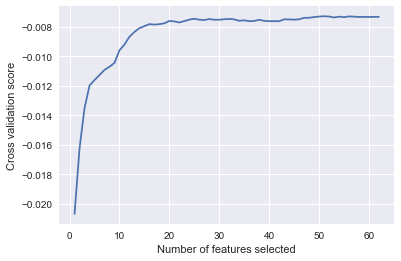

In [369]:
#checking out the curve of those cross-validation scores

#NOTE: arguably, we could have chosen around 20 features and done equally well

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

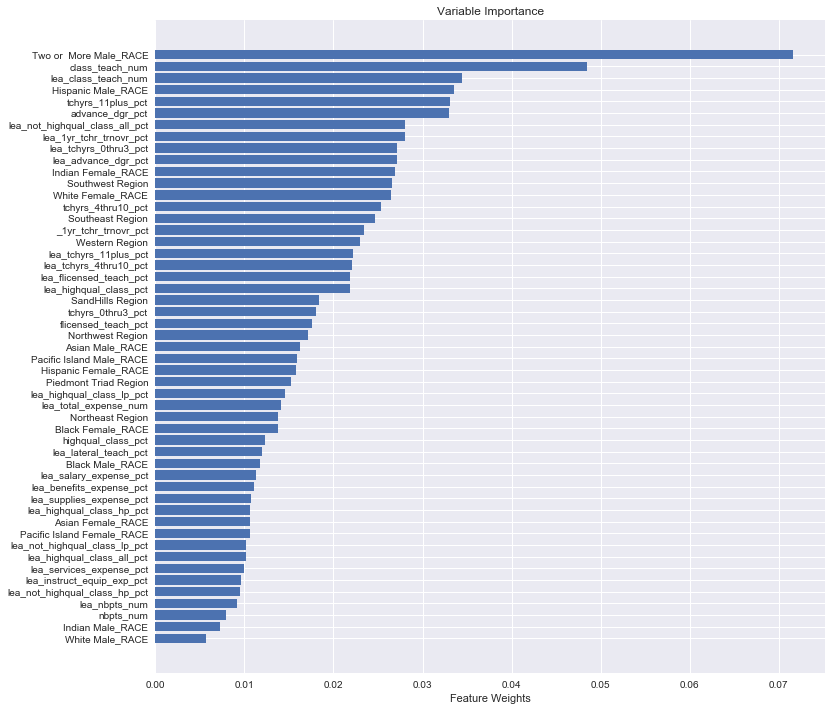

In [372]:
#let's pull out the raw feature importance values to just get the best 20 or so predictors

#NOTE: since the school district can wield no influence over which demographics attend which schools, let's pull out those
#      most important features toward which they might usefully direct their efforts and see how the model performs

feature_importance = clf_7.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12, 12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.asarray(list(gbr_df2.drop(['Overall Achievement Score','Overall Achievement Score Scaled','SPG Score Scaled'],axis=1).columns))[sorted_idx])
plt.xlabel('Feature Weights')
plt.title('Variable Importance')
plt.show()

In [371]:
#NOW-- let's do it one more time, using just the most important and actionable features

In [374]:
#preparing dataframes for train-test-split
#separate target variable and predictors
X = gbr_df2[['class_teach_num','lea_class_teach_num','tchyrs_11plus_pct','advance_dgr_pct','lea_not_highqual_class_all_pct',
             'lea_1yr_tchr_trnovr_pct','lea_tchyrs_0thru3_pct','lea_advance_dgr_pct','tchyrs_4thru10_pct',
             '_1yr_tchr_trnovr_pct','lea_tchyrs_11plus_pct','lea_tchyrs_4thru10_pct','lea_flicensed_teach_pct',
             'lea_highqual_class_pct','tchyrs_0thru3_pct','flicensed_teach_pct','lea_highqual_class_lp_pct',
             'lea_total_expense_num','highqual_class_pct']].astype(np.float32)
y = gbr_df['Overall Achievement Score Scaled']

In [375]:
print(X.shape)
print(y.shape)

(2185, 19)
(2185,)


In [376]:
#scale training predictors
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [377]:
#same optimal hyperparameters identified by GridSearchCV
params = {'n_estimators': 500, 'max_depth': 3, 'min_samples_split':2,
          'learning_rate': 0.05, 'loss': 'ls'}

#building that classifier
clf_8 = ensemble.GradientBoostingRegressor(**params)

#same old drill
indices = range(2185)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.2, random_state=456)

In [378]:
#fit, hit, and quit
clf_8.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [380]:
#NOTE: doesn't perform as well, but the model is probably more interpretable and useful
mse = mean_squared_error(y_test, clf_8.predict(X_test))
print("MSE: %.4f" % mse)

MSE: 0.0127


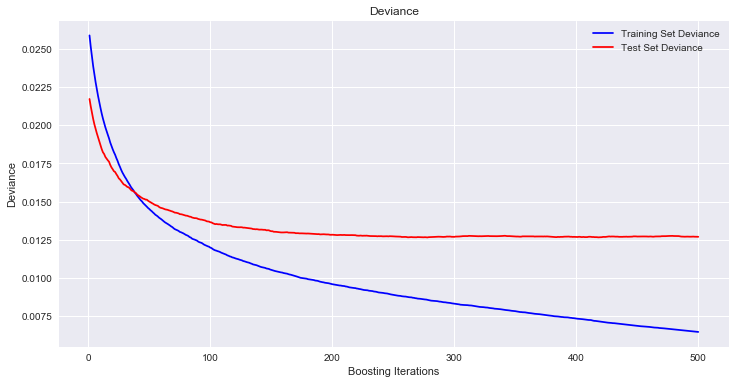

In [381]:
#plot training/testing deviance

#same deal as before
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf_8.staged_predict(X_test)):
    test_score[i] = clf_8.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf_8.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

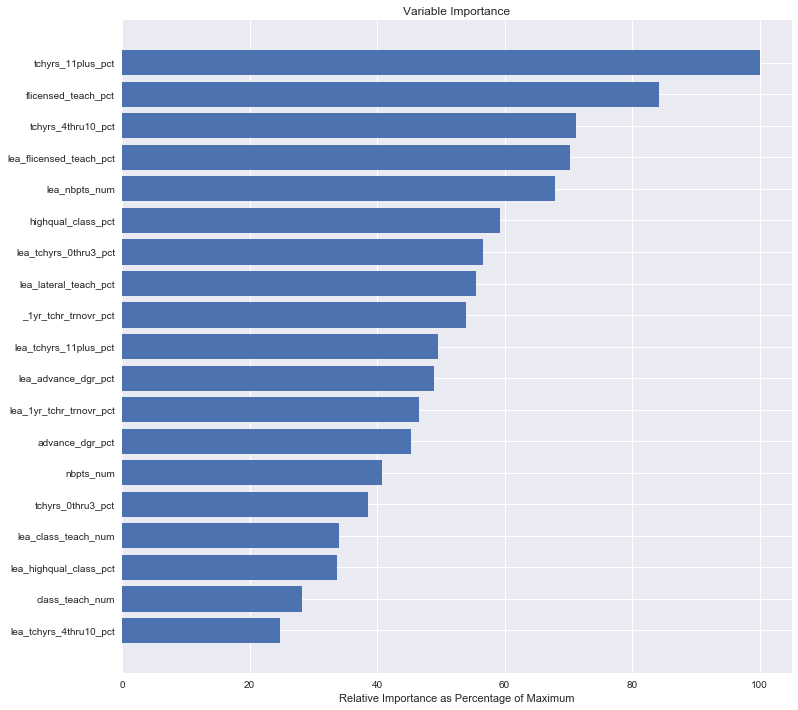

In [384]:
#plot feature importances scaled to their max value
feature_importance = clf_8.feature_importances_

feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12, 12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.asarray(list(gbr_df2.drop(['Overall Achievement Score','Overall Achievement Score Scaled','SPG Score Scaled'],axis=1).columns))[sorted_idx])
plt.xlabel('Relative Importance as Percentage of Maximum')
plt.title('Variable Importance')
plt.show()

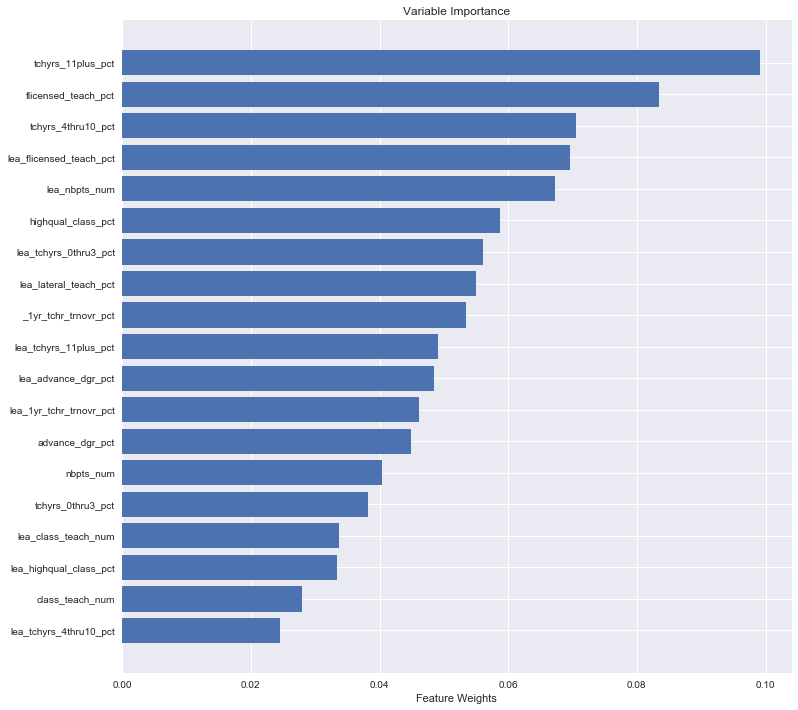

In [385]:
#plot raw feature importances
feature_importance = clf_8.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12, 12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.asarray(list(gbr_df2.drop(['Overall Achievement Score','Overall Achievement Score Scaled','SPG Score Scaled'],axis=1).columns))[sorted_idx])
plt.xlabel('Feature Weights')
plt.title('Variable Importance')
plt.show()

In [ ]:
#As before, retaining well credentialed, fully licensed, and experienced teachers to deliver high quality classes is key!